In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

# Function

In [ ]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
def eval(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [ ]:
def train_test_valid(data):
  train_size = int(0.7 * len(data))
  test_size = int(0.2 * len(data))
  val_size = len(data) - train_size - test_size

  train_data = data[:train_size]
  test_data = data[train_size:train_size+test_size]
  valid_data = data[train_size+test_size:]

  return train_data, test_data, valid_data, train_size, test_size, val_size

# HoaPhat_HPG

## Data

In [ ]:
df_amz = pd.read_csv("/content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Data/cleandata/HoaPhat_HPG_y_m_d.csv")
df_amz

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,10260.39,10443.02,10227.19,10227.19,10227.19,12637219.0
1,2019-01-03,10210.59,10260.39,9795.52,9795.52,9795.52,21178963.0
2,2019-01-04,9762.32,9961.55,9529.88,9861.93,9861.93,20085098.0
3,2019-01-07,10061.16,10077.77,9679.30,9745.71,9745.71,7495579.0
4,2019-01-08,9762.32,9795.52,9529.88,9579.69,9579.69,12767952.0
...,...,...,...,...,...,...,...
1537,2025-03-06,27600.00,27950.00,27600.00,27950.00,27950.00,37159600.0
1538,2025-03-07,28000.00,28100.00,27750.00,28050.00,28050.00,33131210.0
1539,2025-03-10,28100.00,28200.00,27950.00,27950.00,27950.00,23863520.0
1540,2025-03-11,27600.00,28150.00,27600.00,28150.00,28150.00,26088500.0


## Preprocessing

### Check null and na value

In [ ]:
df_amz.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [ ]:
df_amz.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


### Check datatype of each column

In [ ]:
print("Date column data type: ", type(df_amz['Date'][0]))
print("Open column data type: ", type(df_amz['Open'][0]))
print("Close column data type: ", type(df_amz['Close'][0]))
print("High column data type: ", type(df_amz['High'][0]))
print("Low column data type: ", type(df_amz['Low'][0]))
print("Adj Close column data type: ", type(df_amz['Adj Close'][0]))
print("Volume column data type: ", type(df_amz['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [ ]:
df_amz['Date'] = pd.to_datetime(df_amz.Date)

### Choose X

In [ ]:
data_amz =df_amz[['Close']]

## EDA

### Get the duration of dataset

In [ ]:
print("Starting date: ",df_amz.iloc[0][0])
print("Ending date: ", df_amz.iloc[-1][0])
print("Duration: ", df_amz.iloc[-1][0]-df_amz.iloc[0][0])

Starting date:  2019-01-02 00:00:00
Ending date:  2025-03-12 00:00:00
Duration:  2261 days 00:00:00


<ipython-input-12-e30130b711a2>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Starting date: ",df_amz.iloc[0][0])
<ipython-input-12-e30130b711a2>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Ending date: ", df_amz.iloc[-1][0])
<ipython-input-12-e30130b711a2>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Duration: ", df_amz.iloc[-1][0]-df_amz.iloc[0][0])


### Visualize the per day closing price of the stock

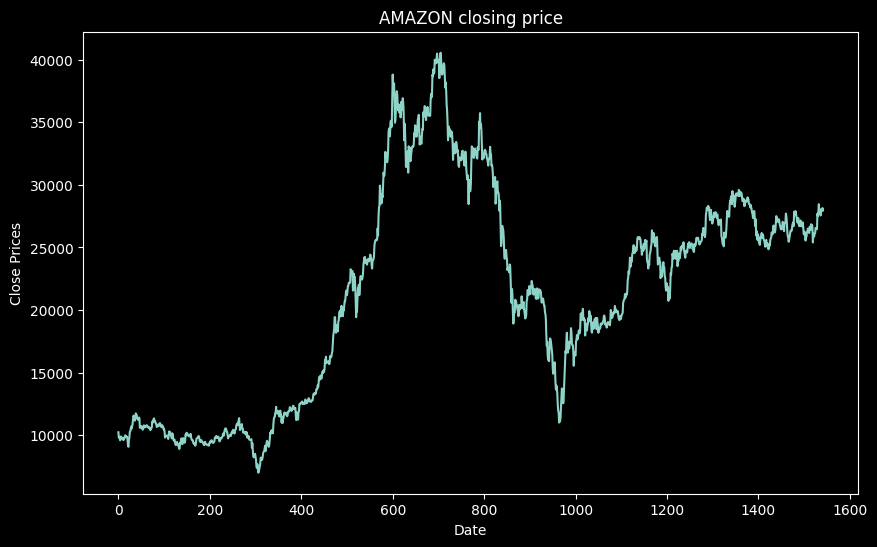

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df_amz['Close'])
plt.title('AMAZON closing price')
plt.show()

## Train, test, valid

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
data_amz = scaler.fit_transform(np.array(data_amz).reshape(-1,1))

In [ ]:
train_data, test_data, valid_data, train_size, test_size, val_size = train_test_valid(data_amz)

In [ ]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(valid_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

## Build & train model

In [ ]:
model = SVR()

### Choose k

In [ ]:
param_grid = {'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

grid = GridSearchCV(model, param_grid, scoring = 'neg_root_mean_squared_error', cv=10)
grid.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=SVR(),
             param_grid={'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             scoring='neg_root_mean_squared_error')

In [ ]:
grid.best_params_

{'kernel': 'linear'}

### Train

In [ ]:
svr = SVR(kernel='linear')
svr.fit(X_train, y_train)

SVR(kernel='linear')

## Eval

In [ ]:
y_pred_val = svr.predict(X_val)
y_pred = svr.predict(X_test)

y_pred_val = y_pred_val.reshape(-1,1)
y_pred = y_pred.reshape(-1,1)

In [ ]:
y_pred_val = scaler.inverse_transform(y_pred_val)
y_pred = scaler.inverse_transform(y_pred)

org_y_val = scaler.inverse_transform(y_val.reshape(-1,1))
org_y_test = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
eval(org_y_test,y_pred,org_y_val,y_pred_val)

** Testing **
MAE:  684.4259167304411
MAPE:  2.6832479273178205
RMSE:  902.6626606608353

** Validate **
MAE:  501.25082898049465
MAPE:  1.860749871708028
RMSE:  645.8270676545584


## Predict

In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=100
i=0
while(i<30):
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)

        yhat = svr.predict(x_input)
        print("{} day output {}".format(i,yhat))

        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1

    else:
        yhat = svr.predict(x_input)
        print(yhat)

        temp_input.extend(yhat.tolist())
        print(len(temp_input))

        lst_output.extend(yhat.tolist())
        i=i+1

[0.62009128]
101
1 day output [0.61818883]
2 day output [0.61573575]
3 day output [0.61470145]
4 day output [0.61455644]
5 day output [0.61426198]
6 day output [0.61355027]
7 day output [0.61190272]
8 day output [0.60967144]
9 day output [0.6075641]
10 day output [0.60651579]
11 day output [0.60631664]
12 day output [0.6068235]
13 day output [0.60641795]
14 day output [0.60650506]
15 day output [0.60509356]
16 day output [0.60237119]
17 day output [0.60046381]
18 day output [0.59845437]
19 day output [0.59732871]
20 day output [0.59572801]
21 day output [0.59386842]
22 day output [0.59050397]
23 day output [0.5876154]
24 day output [0.58504033]
25 day output [0.58309829]
26 day output [0.58251535]
27 day output [0.58183353]
28 day output [0.58083377]
29 day output [0.5793075]


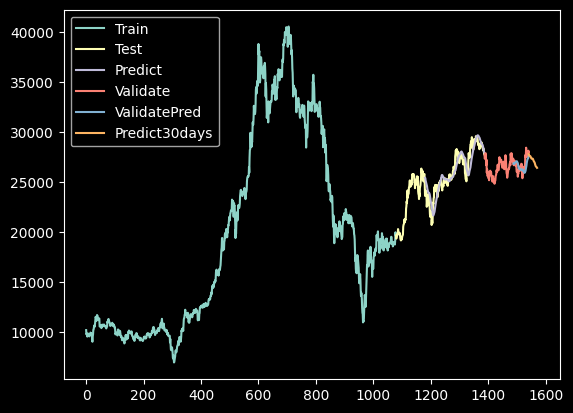

In [ ]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(valid_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(data_amz)-1, stop=len(data_amz)+29, step=1)

plt.plot(prediect_data_index,scaler.inverse_transform(np.array(lst_output).reshape(-1,1)))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

# NamKim_NKG

## Data

In [ ]:
df_tsla = pd.read_csv("/content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Data/cleandata/NamKim_NKG_y_m_d.csv")
df_tsla

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,4565.97,4577.55,4403.94,4403.94,4403.94,65576.0
1,2019-01-03,4403.94,4496.53,4195.60,4195.60,4195.60,559110.0
2,2019-01-04,4195.60,4195.60,3946.76,4079.86,4079.86,116707.0
3,2019-01-07,4079.86,4224.54,4079.86,4079.86,4079.86,132570.0
4,2019-01-08,4079.86,4155.09,4056.71,4079.86,4079.86,137979.0
...,...,...,...,...,...,...,...
1540,2025-03-06,15550.00,16100.00,15500.00,16100.00,16100.00,14202800.0
1541,2025-03-07,16050.00,16300.00,15900.00,16100.00,16100.00,10169700.0
1542,2025-03-10,16150.00,16200.00,15700.00,15800.00,15800.00,9795200.0
1543,2025-03-11,15500.00,16100.00,15400.00,16100.00,16100.00,14542500.0


## Preprocessing

### Check null and na value

In [ ]:
df_tsla.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [ ]:
df_tsla.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


### Check datatype of each column

In [ ]:
print("Date column data type: ", type(df_tsla['Date'][0]))
print("Open column data type: ", type(df_tsla['Open'][0]))
print("Close column data type: ", type(df_tsla['Close'][0]))
print("High column data type: ", type(df_tsla['High'][0]))
print("Low column data type: ", type(df_tsla['Low'][0]))
print("Adj Close column data type: ", type(df_tsla['Adj Close'][0]))
print("Volume column data type: ", type(df_tsla['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [ ]:
df_tsla['Date'] = pd.to_datetime(df_tsla.Date)

### Choose X

In [ ]:
data_tsla =df_tsla[['Close']]

## EDA

### Get the duration of dataset

In [ ]:
print("Starting date: ",df_tsla.iloc[0][0])
print("Ending date: ", df_tsla.iloc[-1][0])
print("Duration: ", df_tsla.iloc[-1][0]-df_tsla.iloc[0][0])

Starting date:  2019-01-02 00:00:00
Ending date:  2025-03-12 00:00:00
Duration:  2261 days 00:00:00


<ipython-input-32-72eea4c1fa3f>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Starting date: ",df_tsla.iloc[0][0])
<ipython-input-32-72eea4c1fa3f>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Ending date: ", df_tsla.iloc[-1][0])
<ipython-input-32-72eea4c1fa3f>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Duration: ", df_tsla.iloc[-1][0]-df_tsla.iloc[0][0])


### Visualize the per day closing price of the stock

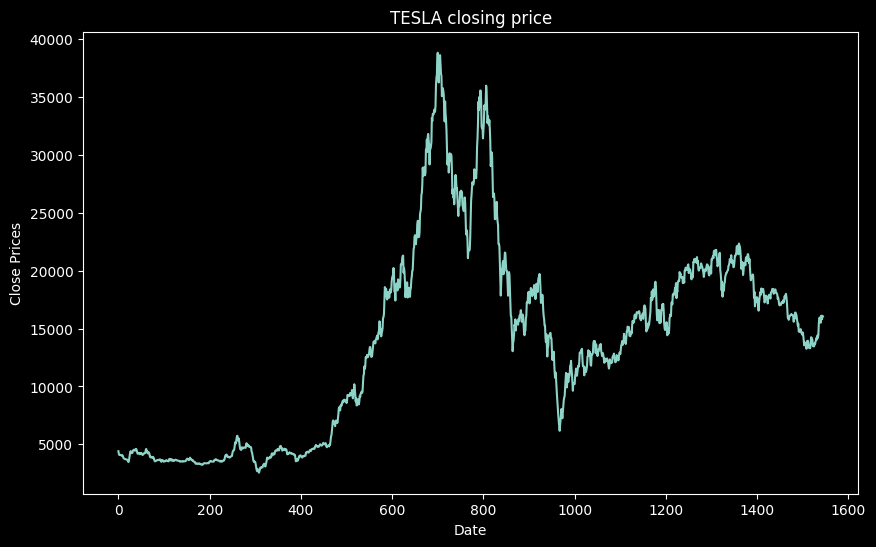

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df_tsla['Close'])
plt.title('TESLA closing price')
plt.show()

## Train, test, valid

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
data_tsla = scaler.fit_transform(np.array(data_tsla).reshape(-1,1))

In [ ]:
train_data, test_data, valid_data, train_size, test_size, val_size = train_test_valid(data_tsla)

In [ ]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(valid_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

## Build & train model

In [ ]:
model = SVR()

### Choose k

In [ ]:
param_grid = {'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

grid = GridSearchCV(model, param_grid, scoring = 'neg_root_mean_squared_error', cv=10)
grid.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=SVR(),
             param_grid={'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             scoring='neg_root_mean_squared_error')

In [ ]:
grid.best_params_

{'kernel': 'linear'}

### Train

In [ ]:
svr = SVR(kernel='linear')
svr.fit(X_train, y_train)

SVR(kernel='linear')

## Eval

In [ ]:
y_pred_val = svr.predict(X_val)
y_pred = svr.predict(X_test)

y_pred_val = y_pred_val.reshape(-1,1)
y_pred = y_pred.reshape(-1,1)

In [ ]:
y_pred_val = scaler.inverse_transform(y_pred_val)
y_pred = scaler.inverse_transform(y_pred)

org_y_val = scaler.inverse_transform(y_val.reshape(-1,1))
org_y_test = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
eval(org_y_test,y_pred,org_y_val,y_pred_val)

** Testing **
MAE:  649.3628177782678
MAPE:  3.5064419423358624
RMSE:  867.8815508908809

** Validate **
MAE:  922.9683719424448
MAPE:  6.541673242042169
RMSE:  1004.5757391230546


## Predict

In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=100
i=0
while(i<30):
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)

        yhat = svr.predict(x_input)
        print("{} day output {}".format(i,yhat))

        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1

    else:
        yhat = svr.predict(x_input)
        print(yhat)

        temp_input.extend(yhat.tolist())
        print(len(temp_input))

        lst_output.extend(yhat.tolist())
        i=i+1

[0.50329367]
101
1 day output [0.50623607]
2 day output [0.50808974]
3 day output [0.50944924]
4 day output [0.50889465]
5 day output [0.50841412]
6 day output [0.50717238]
7 day output [0.50491827]
8 day output [0.50320815]
9 day output [0.5027675]
10 day output [0.50224713]
11 day output [0.50235687]
12 day output [0.50235325]
13 day output [0.50286429]
14 day output [0.50321369]
15 day output [0.50290064]
16 day output [0.50290756]
17 day output [0.50180018]
18 day output [0.50086078]
19 day output [0.50035622]
20 day output [0.50070612]
21 day output [0.50130837]
22 day output [0.50191781]
23 day output [0.50320668]
24 day output [0.50442115]
25 day output [0.50519771]
26 day output [0.50577937]
27 day output [0.50537571]
28 day output [0.50656957]
29 day output [0.50818542]


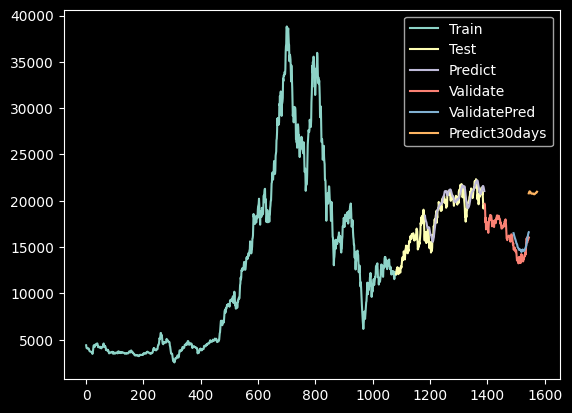

In [ ]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(valid_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(data_tsla)-1, stop=len(data_tsla)+29, step=1)

plt.plot(prediect_data_index,scaler.inverse_transform(np.array(lst_output).reshape(-1,1)))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()